In [1]:
from tensorflow import keras
import ktrain
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
from classification_models.tfkeras import Classifiers

In [3]:
vgg, preproc = Classifiers.get("vgg16")

In [4]:
df = pd.read_csv("Labels.csv")

In [5]:
tr_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.2, 
                                                     height_shift_range=0.2, preprocessing_function=preproc, 
                                                     validation_split=0.2)
ts_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preproc)

In [6]:
train_ims = df[df["Dataset_type"]=="TRAIN"].drop("Dataset_type", 1)
train_ims["Label"] = train_ims["Numeric_Label"].apply(lambda x: "Normal" if x==0 else "Bacterial" if x==1 else "Viral")
train_ims.sample()

,X_ray_image_name,Numeric_Label,Label
3658,IM-0730-0001.jpeg,0,Normal


In [7]:
train = tr_gen.flow_from_dataframe(train_ims, directory="train", x_col="X_ray_image_name", y_col="Label",
                          target_size=(224,224), subset="training")
val = tr_gen.flow_from_dataframe(train_ims, directory="train", x_col="X_ray_image_name", y_col="Label",
                          target_size=(224,224), subset="validation")

Found 4131 validated image filenames belonging to 3 classes.
Found 1032 validated image filenames belonging to 3 classes.


In [8]:
test_ims = df[df["Dataset_type"]=="TEST"].drop("Dataset_type", 1)
test_ims["Label"] = test_ims["Numeric_Label"].apply(lambda x: "Normal" if x==0 else "Bacterial" if x==1 else "Viral")
test_ims.sample()

,X_ray_image_name,Numeric_Label,Label
5316,person144_bacteria_690.jpeg,1,Bacterial


In [9]:
test = ts_gen.flow_from_dataframe(test_ims, directory="test", x_col="X_ray_image_name", y_col="Label",
                          target_size=(224,224))

Found 624 validated image filenames belonging to 3 classes.


In [20]:
base_model = vgg(include_top=False, input_shape=(224,224,3), pooling="avg")
for layer in base_model.layers:
    layer.trainable=False
model = keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dropout(.25))
model.add(keras.layers.Dense(3, activation="softmax"))

In [21]:
model.compile("adam", ["categorical_crossentropy"], ["accuracy"])

In [22]:
learner = ktrain.get_learner(model, train, val)

simulating training for different learning rates... this may take a few moments...
Train for 129 steps
Epoch 1/1024
129/129 [==============================] - 75s 585ms/step - loss: 3.1318 - accuracy: 0.2440
Epoch 2/1024
129/129 [==============================] - 76s 587ms/step - loss: 2.9284 - accuracy: 0.2620
Epoch 3/1024
129/129 [==============================] - 85s 661ms/step - loss: 2.5947 - accuracy: 0.2908
Epoch 4/1024
129/129 [==============================] - 76s 590ms/step - loss: 2.1920 - accuracy: 0.3677
Epoch 5/1024
129/129 [==============================] - 76s 586ms/step - loss: 1.5038 - accuracy: 0.5240
Epoch 6/1024
129/129 [==============================] - 75s 584ms/step - loss: 1.0371 - accuracy: 0.6472
Epoch 7/1024
129/129 [==============================] - 75s 584ms/step - loss: 0.7756 - accuracy: 0.7009
Epoch 8/1024
129/129 [==============================] - 75s 585ms/step - loss: 0.6662 - accuracy: 0.7363
Epoch 9/1024
129/129 [==============================] - 7

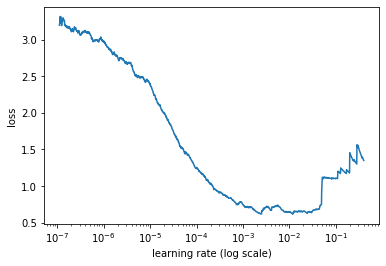

In [23]:
learner.lr_find(show_plot=True)

In [24]:
learner.autofit(1e-3)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train for 130 steps, validate for 33 steps
Epoch 1/1024
130/130 [==============================] - 97s 744ms/step - loss: 1.1300 - accuracy: 0.6509 - val_loss: 0.5735 - val_accuracy: 0.7626
Epoch 2/1024
130/130 [==============================] - 95s 734ms/step - loss: 0.5728 - accuracy: 0.7599 - val_loss: 0.4905 - val_accuracy: 0.7984
Epoch 3/1024
130/130 [==============================] - 97s 749ms/step - loss: 0.5222 - accuracy: 0.7756 - val_loss: 0.4563 - val_accuracy: 0.8023
Epoch 4/1024
130/130 [==============================] - 98s 751ms/step - loss: 0.4985 - accuracy: 0.7957 - val_loss: 0.4615 - val_accuracy: 0.8159
Epoch 5/1024
129/130 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.7978
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 0.0005 (if not early_stoppi

In [27]:
learner.save_model("frozen")

In [28]:
learner.unfreeze()

In [29]:
learner.autofit(1e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 1e-05...
Train for 130 steps, validate for 33 steps
Epoch 1/1024
130/130 [==============================] - 98s 751ms/step - loss: 0.5089 - accuracy: 0.7821 - val_loss: 0.4524 - val_accuracy: 0.8043
Epoch 2/1024
130/130 [==============================] - 97s 746ms/step - loss: 0.4210 - accuracy: 0.8172 - val_loss: 0.3996 - val_accuracy: 0.8149
Epoch 3/1024
130/130 [==============================] - 98s 753ms/step - loss: 0.3809 - accuracy: 0.8332 - val_loss: 0.4110 - val_accuracy: 0.8188
Epoch 4/1024
130/130 [==============================] - 99s 762ms/step - loss: 0.3668 - accuracy: 0.8395 - val_loss: 0.3831 - val_accuracy: 0.8324
Epoch 5/1024
130/130 [==============================] - 99s 765ms/step - loss: 0.3498 - accuracy: 0.8497 - val_loss: 0.3704 - val_accuracy: 0.8333
Epoch 6/1024
130/130 [================

In [30]:
learner.model.save("unfrozen.h5", save_format="h5")

In [31]:
learner.save_model("unfrozen")

In [32]:
res = learner.model.evaluate(test)

In [33]:
res

[0.8283946678042412, 0.80608976]